In [162]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool, global_add_pool
from torch_geometric.data import Data, Batch
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch_geometric.loader import DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

class TimeSeriesGraphTransformer(nn.Module):
    def __init__(self, input_dim, model_dim, num_heads, num_layers, output_dim=4, dropout=0.1,
                 sequence_length=10, pooling="mean", use_positional_encoding=False, n_global_features=0,
                 hidden_layers=(64, 32)):
        super(TimeSeriesGraphTransformer, self).__init__()
        self.sequence_length = sequence_length
        self.use_positional_encoding = use_positional_encoding
        self.n_global_features = n_global_features

        self.gcn1 = GCNConv(input_dim, model_dim)
        self.gcn2 = GCNConv(model_dim, model_dim)

        self.pooling = pooling
        if pooling not in ["mean", "sum"]:
            raise ValueError("Pooling must be either 'mean' or 'sum'")

        self.positional_encoding = nn.Parameter(torch.randn(sequence_length, model_dim)) if use_positional_encoding else None

        encoder_layer = TransformerEncoderLayer(d_model=model_dim, nhead=num_heads, dropout=dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Feedforward layers after Transformer
        fc_input_dim = model_dim + n_global_features
        fc_layers = []
        for hidden_dim in hidden_layers:
            fc_layers.append(nn.Linear(fc_input_dim, hidden_dim))
            fc_layers.append(nn.ReLU())
            fc_input_dim = hidden_dim
        fc_layers.append(nn.Linear(fc_input_dim, output_dim))
        self.output_layers = nn.Sequential(*fc_layers)

    def forward(self, batched_graphs):
        x, edge_index, batch = batched_graphs.x, batched_graphs.edge_index, batched_graphs.batch

        x = F.relu(self.gcn1(x, edge_index))
        x = self.gcn2(x, edge_index)

        if self.pooling == "mean":
            graph_features = global_mean_pool(x, batch)
        else:
            graph_features = global_add_pool(x, batch)

        num_graphs = graph_features.size(0)
        if num_graphs % self.sequence_length != 0:
            raise ValueError(f"Expected num_graphs % sequence_length == 0, got {num_graphs} and {self.sequence_length}")

        batch_size = num_graphs // self.sequence_length
        graph_features = graph_features.view(self.sequence_length, batch_size, -1)  # [seq_len, batch, model_dim]

        if self.use_positional_encoding:
            graph_features += self.positional_encoding.unsqueeze(1)

        transformer_output = self.transformer_encoder(graph_features)  # [seq_len, batch, model_dim]

        global_features = getattr(batched_graphs, 'global_features', None)
        if self.n_global_features > 0:
            if global_features is None:
                raise ValueError("Expected global_features in batch but got None.")
            if global_features.shape[0] != batch_size:
                raise ValueError(f"Expected one global vector per sequence (batch), got {global_features.shape}")
            global_features = global_features.unsqueeze(0).repeat(self.sequence_length, 1, 1)  # [seq_len, batch, n_global_features]
            transformer_output = torch.cat((transformer_output, global_features), dim=-1)  # [seq_len, batch, model_dim + n_global_features]

        # Pass each time step through the MLP
        output = self.output_layers(transformer_output)  # [seq_len, batch, output_dim]
        output = F.sigmoid(output)
        return output.permute(1, 0, 2)  # [batch, seq_len, output_dim]

class GraphSequenceDataset(torch.utils.data.Dataset):
    def __init__(self, data, sequence_length):
        self.sequence_length = sequence_length
        self.sequences = []
        self.targets = []
        self.global_features = []
        for subject in data:
            subject_data = data[subject].sort_values(by='Time').reset_index(drop=True)
            graphs = [self.create_graph(subject_data, i) for i in range(len(subject_data))]
            numeric_targets = subject_data[['BRA', 'BIC', 'TRI', 'BRD']].apply(pd.to_numeric, errors='coerce').fillna(0).values.astype(np.float32)

            for i in range(len(graphs) - 2*sequence_length):
                self.sequences.append(graphs[i:i + sequence_length])
                self.targets.append(numeric_targets[i+sequence_length:i + 2*sequence_length])
                self.global_features.append(graphs[i].global_features[0])  # assume same global_features across seq

    def create_graph(self, df, t):
        muscles = ['BRD', 'BRA', 'BIC', 'TRI']
        node_exclude = ['Mz', 'Subject'] + muscles
        node_columns = [col for col in df.columns if col not in node_exclude]

        edge_index = torch.combinations(torch.arange(len(muscles)), r=2).t()
        edge_index = torch.cat([edge_index, edge_index.flip(0)], dim=1)

        node_feats = torch.tensor(df.iloc[t][muscles].apply(pd.to_numeric, errors='coerce').fillna(0).values.reshape(4, 1), dtype=torch.float32)
        additional_feats = torch.tensor(df.iloc[t][node_columns].apply(pd.to_numeric, errors='coerce').fillna(0).values, dtype=torch.float32).unsqueeze(0).repeat(4, 1)

        data = Data(x=node_feats, edge_index=edge_index)
        data.global_features = additional_feats  # per-graph copy for now
        return data

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], torch.tensor(self.targets[idx], dtype=torch.float32), torch.tensor(self.global_features[idx], dtype=torch.float32)

def collate_fn(batch):
    graph_seqs, targets, global_feats = zip(*batch)
    flat_graphs = [g for seq in graph_seqs for g in seq]
    targets = torch.stack(targets)
    global_feats = torch.stack(global_feats)
    return flat_graphs, targets, global_feats


class DataBySubject():
    def __init__(self, data, scale_data=True):
        self.data = pd.get_dummies(data, columns=["Sex"], drop_first=True)
        self.data['Sex_M'] = self.data['Sex_M'].astype(np.float32)
        self.subjects = self.data["Subject"].unique()
        # for each numeric column use sklearn to minmax scale
        numeric_columns = self.data.select_dtypes(include=[np.number]).columns.tolist()
        scaler = MinMaxScaler()
        if scale_data is True:
            for col in numeric_columns:
                self.data[col] = scaler.fit_transform(self.data[[col]])
        self.data_by_subject = {subj: self.data[self.data["Subject"] == subj] for subj in self.subjects}
    def __getitem__(self, x):
        return self.data_by_subject[self.subjects[x]]
    def __len__(self):
        return len(self.data_by_subject)
    
# Initialize data and dataset
sequence_length = 10
raw_data = pd.read_pickle("/home/funsega/kmk/data/EF_Fatigued_Recorded.pkl")
data = DataBySubject(raw_data)
dataset = GraphSequenceDataset(data.data_by_subject, sequence_length=sequence_length)




In [176]:
dataloader = DataLoader(dataset, batch_size=128, shuffle=True, collate_fn=collate_fn)
# (rest of the code unchanged, only model class modified to support global features and MLP)
sequence_length = sequence_length
# Initialize model
model = TimeSeriesGraphTransformer(input_dim=1, model_dim=2, num_heads=2, num_layers=2,
                                   sequence_length=sequence_length, output_dim=4, pooling="mean", n_global_features=12, hidden_layers=(128, 64))
model



/home/funsega/miniconda3/envs/venv/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


TimeSeriesGraphTransformer(
  (gcn1): GCNConv(1, 2)
  (gcn2): GCNConv(2, 2)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=2, out_features=2, bias=True)
        )
        (linear1): Linear(in_features=2, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=2, bias=True)
        (norm1): LayerNorm((2,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((2,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (output_layers): Sequential(
    (0): Linear(in_features=14, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, 

In [177]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters in the model: {total_params}")

Total number of parameters in the model: 30994


/tmp/ipykernel_92068/3005703236.py:116: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.sequences[idx], torch.tensor(self.targets[idx], dtype=torch.float32), torch.tensor(self.global_features[idx], dtype=torch.float32)


Epoch 1/100, Loss: 0.0319
Epoch 2/100, Loss: 0.0270
Epoch 3/100, Loss: 0.0241
Epoch 4/100, Loss: 0.0226
Epoch 5/100, Loss: 0.0215
Epoch 6/100, Loss: 0.0207
Epoch 7/100, Loss: 0.0199
Epoch 8/100, Loss: 0.0193
Epoch 9/100, Loss: 0.0187
Epoch 10/100, Loss: 0.0183
Epoch 11/100, Loss: 0.0179
Epoch 12/100, Loss: 0.0175
Epoch 13/100, Loss: 0.0170
Epoch 14/100, Loss: 0.0167
Epoch 15/100, Loss: 0.0163
Epoch 16/100, Loss: 0.0160
Epoch 17/100, Loss: 0.0158
Epoch 18/100, Loss: 0.0155
Epoch 19/100, Loss: 0.0153
Epoch 20/100, Loss: 0.0151
Epoch 21/100, Loss: 0.0150
Epoch 22/100, Loss: 0.0148
Epoch 23/100, Loss: 0.0146
Epoch 24/100, Loss: 0.0144
Epoch 25/100, Loss: 0.0143
Epoch 26/100, Loss: 0.0142
Epoch 27/100, Loss: 0.0140
Epoch 28/100, Loss: 0.0140
Epoch 29/100, Loss: 0.0138
Epoch 30/100, Loss: 0.0137
Epoch 31/100, Loss: 0.0136
Epoch 32/100, Loss: 0.0136
Epoch 33/100, Loss: 0.0135
Epoch 34/100, Loss: 0.0134
Epoch 35/100, Loss: 0.0134
Epoch 36/100, Loss: 0.0132
Epoch 37/100, Loss: 0.0132
Epoch 38/1

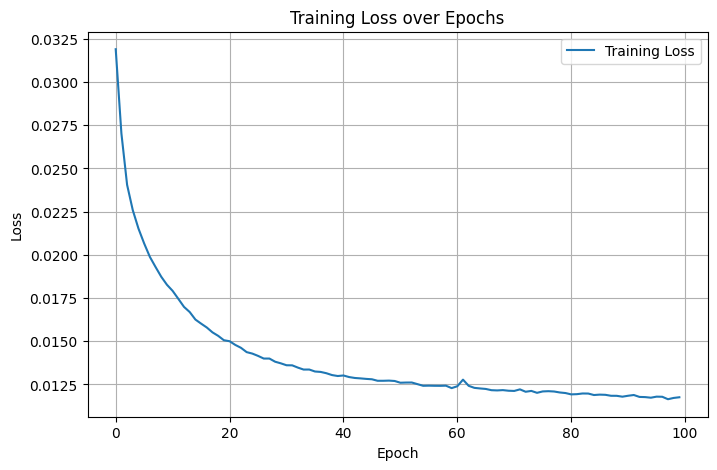

In [178]:

epochs = 100
learning_rate = 1e-3
losses = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()
try:
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for flat_graphs, targets, global_features in dataloader:
            batched_graphs = Batch.from_data_list(flat_graphs)
            batched_graphs.global_features = global_features
            batched_graphs = batched_graphs.to(device)
            targets = targets.to(device)
            optimizer.zero_grad()
            output = model(batched_graphs)
            # output = output[:, -1, :]  # last time step prediction
            loss = criterion(output, targets)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(dataloader)
        losses.append(avg_loss)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")
except KeyboardInterrupt:
    print("training interupted")

# Plot training loss
plt.figure(figsize=(8, 5))
plt.plot(losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss over Epochs")
plt.grid(True)
plt.legend()
plt.show()


/tmp/ipykernel_92068/3005703236.py:116: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.sequences[idx], torch.tensor(self.targets[idx], dtype=torch.float32), torch.tensor(self.global_features[idx], dtype=torch.float32)


R²: -0.4841
MAE: 0.1852


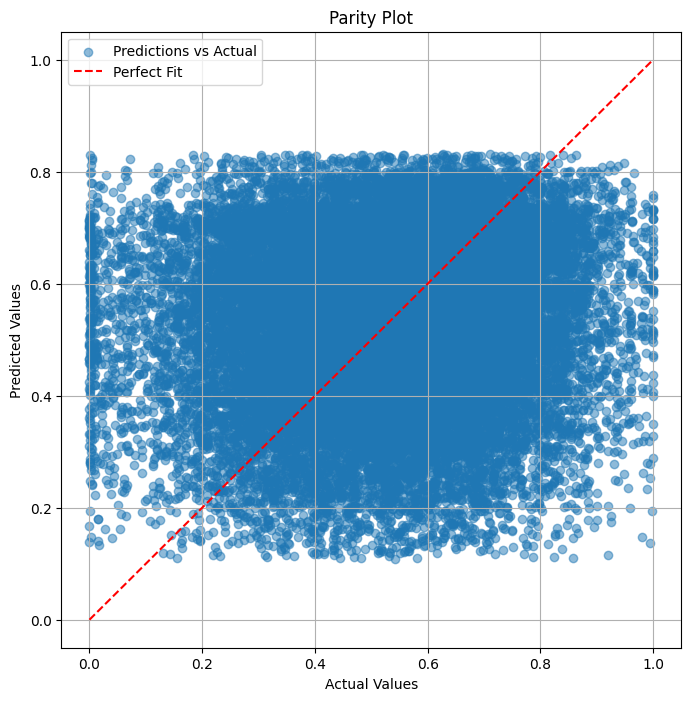

In [179]:
from sklearn.metrics import r2_score, mean_absolute_error

# Switch model to evaluation mode
model.eval()

all_predictions = []
all_actual_targets = []

# Iterate through the dataloader
with torch.no_grad():
    for batched_graphs, targets, global_features in dataloader:
        batched_graphs = Batch.from_data_list(batched_graphs)
        batched_graphs.global_features = global_features
        batched_graphs = batched_graphs.to(device)
        targets = targets.to(device)

        # Get model predictions
        output = model(batched_graphs)
        output = output[:, -1, :]  # Take the last time step prediction

        all_predictions.append(output.cpu().numpy())
        all_actual_targets.append(targets.cpu().numpy())

# Flatten the predictions and actual targets for comparison
predictions_flat = np.concatenate(all_predictions).flatten()
actual_target_flat = np.concatenate(all_actual_targets).flatten()

# Ensure both arrays have the same length
min_length = min(len(predictions_flat), len(actual_target_flat))
predictions_flat = predictions_flat[:min_length]
actual_target_flat = actual_target_flat[:min_length]

# Calculate R² and MAE
r2 = r2_score(actual_target_flat, predictions_flat)
mae = mean_absolute_error(actual_target_flat, predictions_flat)

print(f"R²: {r2:.4f}")
print(f"MAE: {mae:.4f}")

# Create a parity plot
plt.figure(figsize=(8, 8))
plt.scatter(actual_target_flat, predictions_flat, alpha=0.5, label="Predictions vs Actual")
plt.plot([actual_target_flat.min(), actual_target_flat.max()],
         [actual_target_flat.min(), actual_target_flat.max()],
         color='red', linestyle='--', label="Perfect Fit")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Parity Plot")
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipykernel_92068/1555209544.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['Sex'] = ['M' if i > 1 else 0 for i in test_df['Sex_M']]
/tmp/ipykernel_92068/3005703236.py:116: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.sequences[idx], torch.tensor(self.targets[idx], dtype=torch.float32), torch.tensor(self.global_features[idx], dtype=torch.float32)
/tmp/ipykernel_92068/1555209544.py:49: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colo

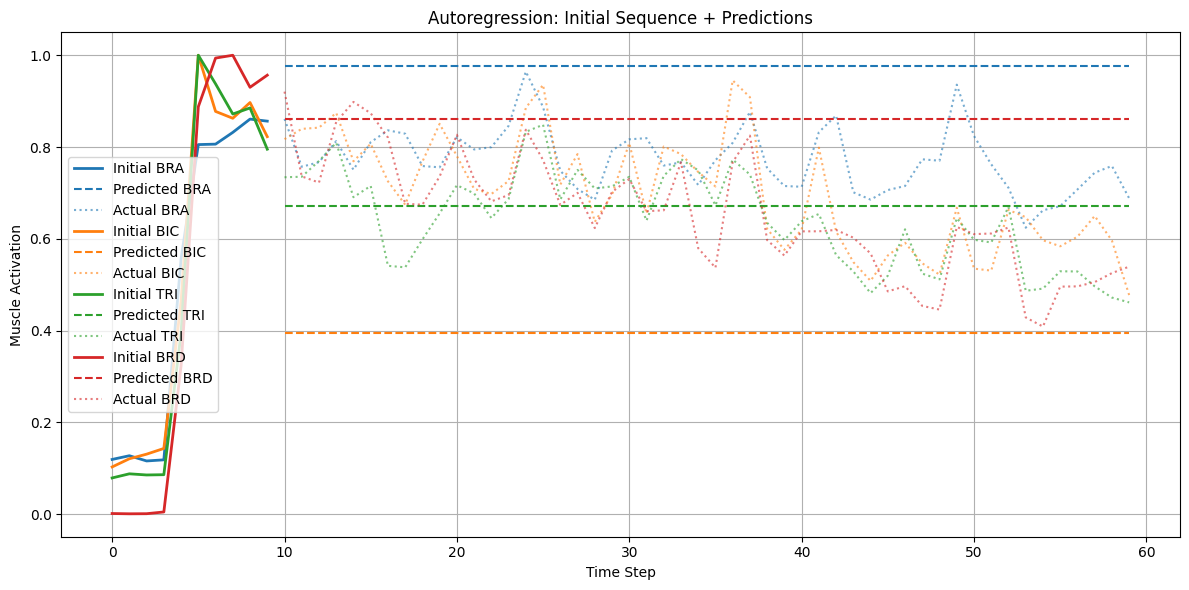

In [183]:

def autoregress(model, initial_sequence, num_steps, device='cpu'):
    model.eval()
    sequence_length = model.sequence_length
    current_sequence = initial_sequence
    predictions = []

    with torch.no_grad():
        for _ in range(num_steps):
            batch = Batch.from_data_list(current_sequence).to(device)

            # Assign single global vector per sequence
            graph = current_sequence[-1]
            global_feat = graph.global_features[0].unsqueeze(0)  # shape: [1, n_global_features]
            batch.global_features = global_feat.to(device)

            # Get model predictions
            output = model(batch)  # Shape: [1, sequence_length, output_dim]
            pred = output[:, -1, :]  # Extract the last time step's prediction, shape: [1, output_dim]
            predictions.append(pred.squeeze(0).cpu().numpy())  # Remove batch dimension, shape: [output_dim]

            # Update the sequence with the new prediction
            new_graph = current_sequence[-1].clone()
            new_graph.x[:, 0] = pred.squeeze(0).to(new_graph.x.device)  # Update activations
            new_graph.global_features = graph.global_features  # Preserve global features
            current_sequence = current_sequence[1:] + [new_graph]

    return np.array(predictions)
n = np.random.randint(0, len(data))
test_df = data[n]
test_df['Sex'] = ['M' if i > 1 else 0 for i in test_df['Sex_M']]
test_data = DataBySubject(data[n])
test_dataset = GraphSequenceDataset(test_data.data_by_subject, sequence_length=sequence_length)
sequence_data, targets, global_feats = test_dataset[0]
# 🔢 Seed from a real example
predictions = autoregress(model, sequence_data, num_steps=50, device=device)

# Extract ground truth from subject
subject_df = test_df
ground_truth = subject_df[['BRA', 'BIC', 'TRI', 'BRD']].values

initial_values = ground_truth[:model.sequence_length]
predicted_values = predictions
true_future = ground_truth[model.sequence_length:model.sequence_length + len(predictions)]
from matplotlib.cm import get_cmap

import matplotlib.pyplot as plt

# Use tab10 colormap
cmap = get_cmap("tab10")

plt.figure(figsize=(12, 6))
labels = ['BRA', 'BIC', 'TRI', 'BRD']
for i, label in enumerate(labels):
    color = cmap(i)  # Get the color for the current label

    # Initial sequence
    plt.plot(range(model.sequence_length),
             initial_values[:, i], label=f'Initial {label}', linewidth=2, color=color)

    # Predictions
    plt.plot(range(model.sequence_length, model.sequence_length + len(predicted_values)),
             predicted_values[:, i], linestyle='--', label=f'Predicted {label}', color=color)

    # Optional: Ground truth
    plt.plot(range(model.sequence_length, model.sequence_length + len(predicted_values)),
             true_future[:, i], linestyle=':', label=f'Actual {label}', color=color, alpha=0.6)

plt.xlabel("Time Step")
plt.ylabel("Muscle Activation")
plt.title("Autoregression: Initial Sequence + Predictions")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



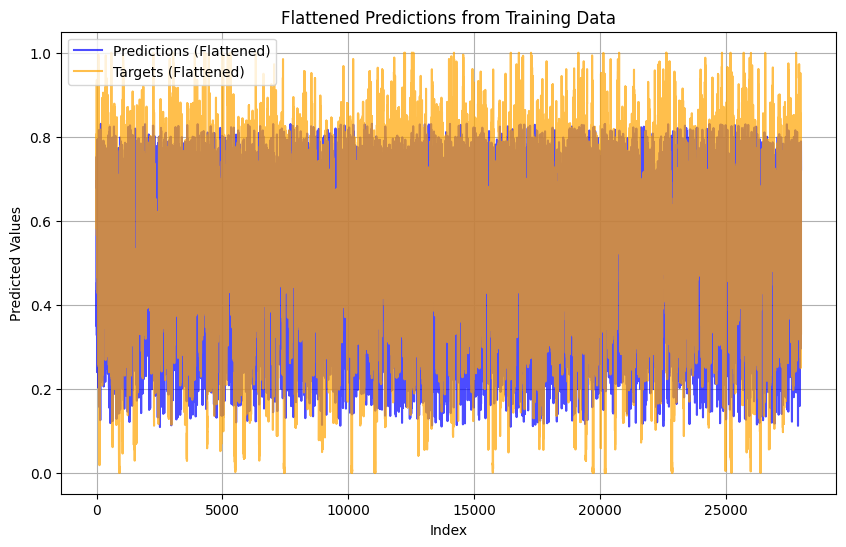

In [181]:
# Plot the predictions from the training data as a flattened vector
plt.figure(figsize=(10, 6))
plt.plot(predictions_flat, label="Predictions (Flattened)", color="blue", alpha=0.7)
plt.plot(actual_target_flat, label="Targets (Flattened)", color="orange", alpha=0.7)
plt.xlabel("Index")
plt.ylabel("Predicted Values")
plt.title("Flattened Predictions from Training Data")
plt.legend()
plt.grid(True)
plt.show()

In [90]:
test_data.data

,Time,BIC,BRD,TRI,BRA,Subject,Mz,MVC,Age,Height,Mass,Hand Length,Hand Width,Forearm Length,Elbow Width,Upper Arm Length,Handedness,Sex_M
0,0.000000,0.000000,0.000000,0.000877,0.000000,WIC10,0.730683,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.003344,0.000165,0.002708,0.000000,0.000853,WIC10,0.158808,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.006689,0.001318,0.010859,0.004389,0.003534,WIC10,0.035676,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.010033,0.081171,0.111375,0.100162,0.201940,WIC10,0.017357,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.013378,0.241034,0.416110,0.168215,0.327156,WIC10,0.046357,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,0.986622,0.034416,0.037011,0.027506,0.037707,WIC10,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
296,0.989967,0.028490,0.020380,0.003153,0.002279,WIC10,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
297,0.993311,0.012974,0.018470,0.001242,0.000660,WIC10,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
298,0.996656,0.004913,0.014545,0.001984,0.000634,WIC10,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [295]:
muscles = ['BRD', 'BRA', 'BIC', 'TRI']
node_exclude = ['Mz', 'Subject'] + muscles
node_columns = [col for col in data[0].columns if col not in node_exclude]
node_columns

['Time',
 'MVC',
 'Age',
 'Height',
 'Mass',
 'Hand Length',
 'Hand Width',
 'Forearm Length',
 'Elbow Width',
 'Upper Arm Length',
 'Handedness',
 'Sex_M']

R²: 0.6977
MAE: 0.0772


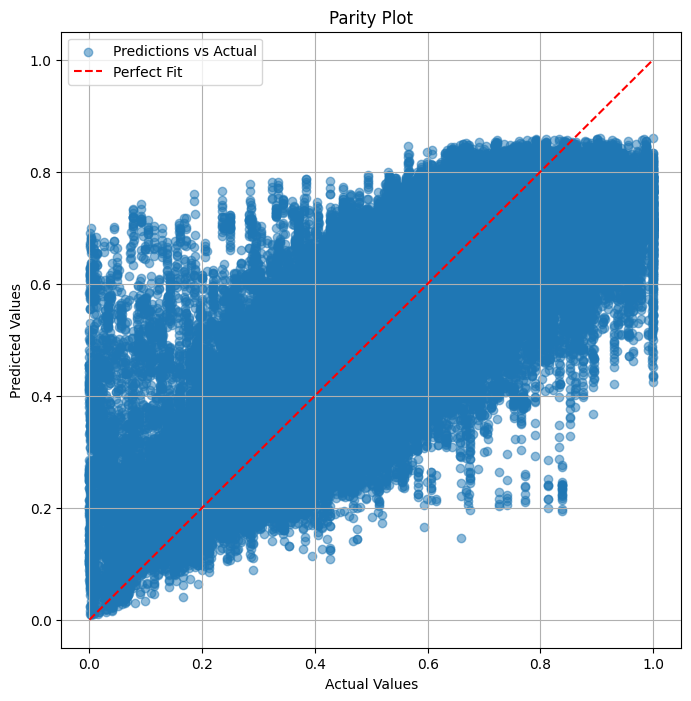

In [296]:
from sklearn.metrics import r2_score, mean_absolute_error

# Switch model to evaluation mode
model.eval()

all_predictions = []
all_actual_targets = []

# Iterate through the dataloader
with torch.no_grad():
    for sequences, targets, global_features in dataloader:
        sequences = sequences.to(device)
        targets = targets.to(device)
        global_features = global_features.to(device)

        # Get model predictions
        outputs = model(sequences, global_features)
        all_predictions.append(outputs.cpu().numpy())
        all_actual_targets.append(targets.cpu().numpy())

# Flatten the predictions and actual targets for comparison
predictions_flat = np.concatenate(all_predictions).flatten()
actual_target_flat = np.concatenate(all_actual_targets).flatten()

# Ensure both arrays have the same length
min_length = min(len(predictions_flat), len(actual_target_flat))
predictions_flat = predictions_flat[:min_length]
actual_target_flat = actual_target_flat[:min_length]

# Calculate R² and MAE
r2 = r2_score(actual_target_flat, predictions_flat)
mae = mean_absolute_error(actual_target_flat, predictions_flat)

print(f"R²: {r2:.4f}")
print(f"MAE: {mae:.4f}")

# Create a parity plot
plt.figure(figsize=(8, 8))
plt.scatter(actual_target_flat, predictions_flat, alpha=0.5, label="Predictions vs Actual")
plt.plot([actual_target_flat.min(), actual_target_flat.max()],
         [actual_target_flat.min(), actual_target_flat.max()],
         color='red', linestyle='--', label="Perfect Fit")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Parity Plot")
plt.legend()
plt.grid(True)
plt.show()